BOX 1: reading packages

In [1]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import chisquare


BOX 2 reading the csv + checking each column for null values

In [2]:
df = pd.read_csv('udemy_database.csv')
has_nulls = df.isnull().any()
print(has_nulls)

course_id              False
course_title           False
url                    False
is_paid                False
price                  False
num_subscribers        False
num_reviews            False
num_lectures           False
level                  False
content_duration       False
published_timestamp    False
subject                False
dtype: bool


BOX 3 checking for duplicates - there where 6 duplicates

In [3]:
duplicates = df[df.duplicated(subset='course_id')]
print(f"Number of duplicates found: {len(duplicates)}")

df.drop_duplicates(subset='course_id', keep='first', inplace=True)

print(f"Row count after removing duplicates: {len(df)}")

df.to_csv('udemy_database.csv', index=False)

Number of duplicates found: 0
Row count after removing duplicates: 3672


In [4]:
min_date = df['published_timestamp'].min()
max_date = df['published_timestamp'].max()

print(f"Lowest date of publication: {min_date}")
print(f"Highest date of publication: {max_date}")

Lowest date of publication: 2011-07-09T05:43:31Z
Highest date of publication: 2017-07-06T21:46:30Z


BOX 4: detecting outliers
method: https://bpb-us-w2.wpmucdn.com/sites.umassd.edu/dist/f/1316/files/2023/01/Statistics-for-Nursing-and-Allied-Health-PDFDrive-.pdf#page=34
Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69

In [5]:
outliers_dict = {}

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    mean = df[column].mean()
    std_dev = df[column].std()

    outliers = df[(df[column] < (mean - 3 * std_dev)) | (df[column] > (mean + 3 * std_dev))]

    outliers_dict[column] = outliers
    outliers_count = len(outliers)
    
    print(f"Column: {column}, Outliers Count: {outliers_count}")


Column: course_id, Outliers Count: 0
Column: price, Outliers Count: 0
Column: num_subscribers, Outliers Count: 48
Column: num_reviews, Outliers Count: 27
Column: num_lectures, Outliers Count: 73
Column: content_duration, Outliers Count: 69


In [6]:
mean = df["content_duration"].mean()
std_dev = df["content_duration"].std()

outliers = df[(df["content_duration"] < (mean - 3 * std_dev)) | (df["content_duration"] > (mean + 3 * std_dev))]

outliers.to_csv('outliers_content_duration.csv', index=False)


BOX 4: the outliers intersection based on numeric variables

In [7]:
common_outliers_pairwise = {}

for col1, col2 in combinations(outliers_dict.keys(), 2):
    outliers_col1 = set(outliers_dict[col1]['course_id']) if isinstance(outliers_dict[col1], pd.DataFrame) else set(outliers_dict[col1])
    outliers_col2 = set(outliers_dict[col2]['course_id']) if isinstance(outliers_dict[col2], pd.DataFrame) else set(outliers_dict[col2])

    common_outliers = outliers_col1.intersection(outliers_col2)

    common_outliers_pairwise[f"{col1} & {col2}"] = common_outliers

for columns, common_outliers in common_outliers_pairwise.items():
    print(f"Common outliers for {columns}:", len(common_outliers))
    for course_id in common_outliers:
        print(f"  - Course ID {course_id}")
    print()



Common outliers for course_id & price: 0

Common outliers for course_id & num_subscribers: 0

Common outliers for course_id & num_reviews: 0

Common outliers for course_id & num_lectures: 0

Common outliers for course_id & content_duration: 0

Common outliers for price & num_subscribers: 0

Common outliers for price & num_reviews: 0

Common outliers for price & num_lectures: 0

Common outliers for price & content_duration: 0

Common outliers for num_subscribers & num_reviews: 20
  - Course ID 764164
  - Course ID 364426
  - Course ID 130064
  - Course ID 519442
  - Course ID 437398
  - Course ID 719002
  - Course ID 405926
  - Course ID 625204
  - Course ID 756150
  - Course ID 446134
  - Course ID 473160
  - Course ID 48841
  - Course ID 289230
  - Course ID 41295
  - Course ID 238934
  - Course ID 314462
  - Course ID 461160
  - Course ID 173548
  - Course ID 705264
  - Course ID 707962

Common outliers for num_subscribers & num_lectures: 10
  - Course ID 764164
  - Course ID 11174
 

BOX 6: plotting the data to better see the outliers

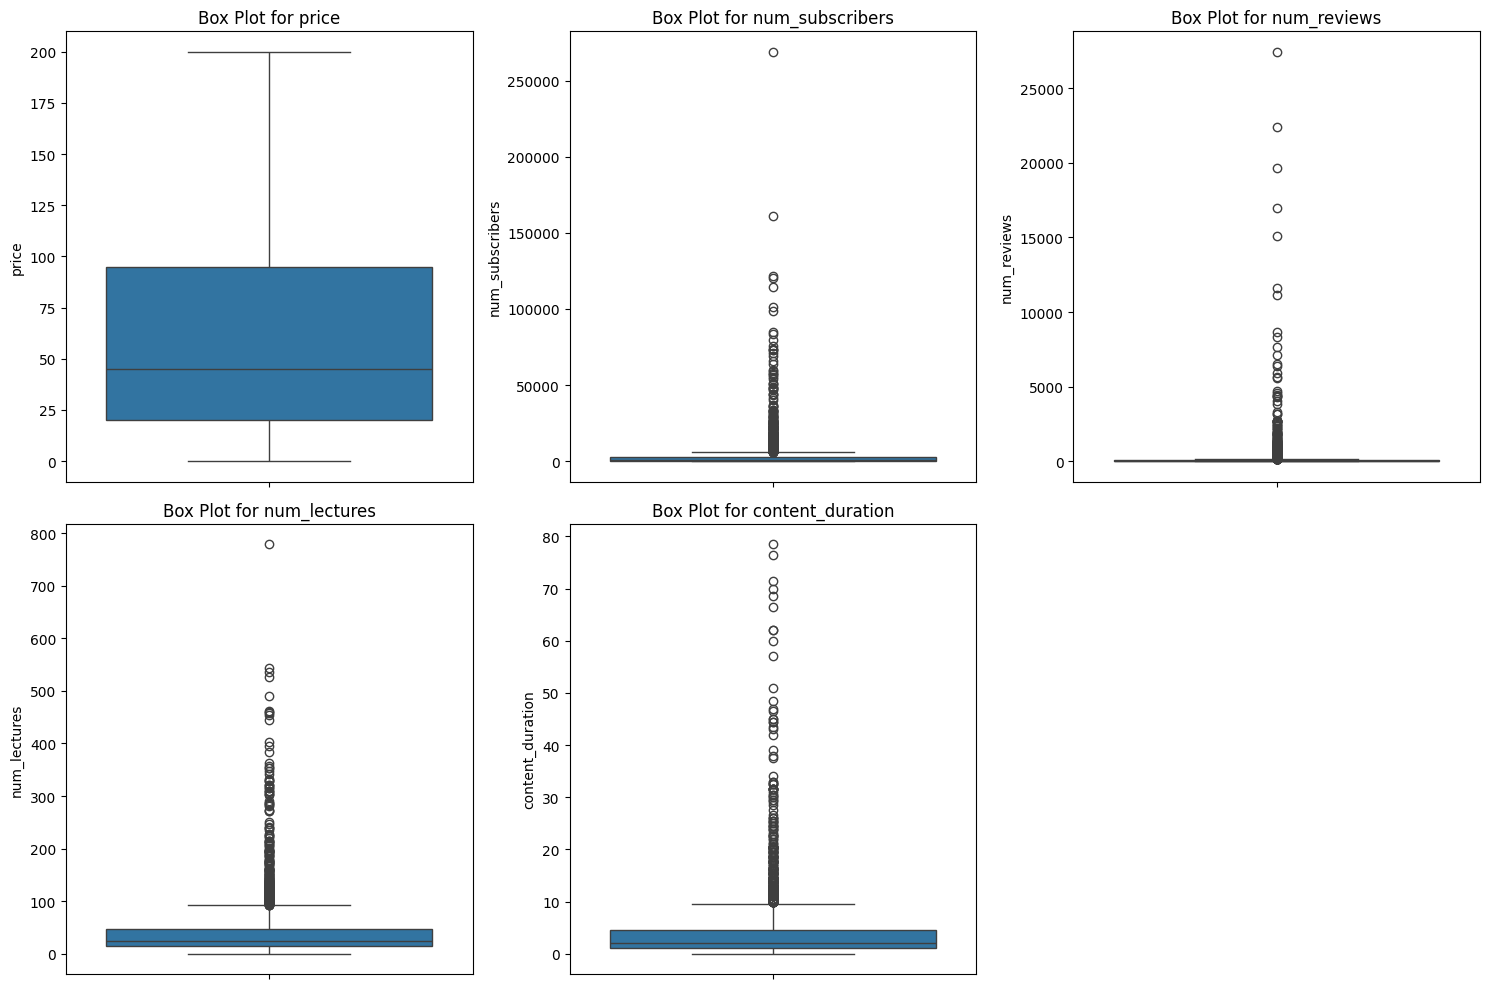

In [8]:
numerical_cols = ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

num_cols = len(numerical_cols)
rows = (num_cols + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten() 

for i, column in enumerate(numerical_cols):
    sns.boxplot(y=df[column], ax=axes[i])  
    axes[i].set_title(f'Box Plot for {column}')
    axes[i].set_ylabel(column)

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()


Dropping some outliers

In [41]:
df_outliers_num_subs = pd.read_csv('outliers_num_subscribers.csv')
outliers_num_subs = df_outliers_num_subs[(df_outliers_num_subs["subject"]) != "Web Development"]
print(outliers_num_subs["course_id"].count())

df_outliers_content_duration = pd.read_csv('outliers_content_duration.csv')
noutliers_content_duration = df_outliers_content_duration[(df_outliers_content_duration["content_duration"]) >= 40]
print(noutliers_content_duration["course_id"].count())

df_outliers_num_lectures= pd.read_csv('outliers_num_lectures.csv')	
outliers_num_lectures = df_outliers_num_lectures[(df_outliers_num_lectures["num_lectures"]) >= 400]
print(outliers_num_lectures["course_id"].count())

df_outliers_num_reviews = pd.read_csv('outliers_num_reviews.csv')
outliers_num_reviews = df_outliers_num_reviews[
    (df_outliers_num_reviews["num_reviews"] >= 10000) | (df_outliers_num_reviews["subject"] != "Web Development")]
print(outliers_num_reviews["course_id"].count())

all_outliers = pd.concat([outliers_num_subs, noutliers_content_duration, outliers_num_lectures, outliers_num_reviews]).drop_duplicates(subset="course_id")
print(all_outliers["course_id"].count())

print("Number of unique outliers identified:", len(all_outliers["course_id"].unique()))

print("Total number of rows before removing outliers:", len(df))
print("Number of rows to remove:", len(all_outliers))

df_no_outliers_udemy = df[~df["course_id"].isin(all_outliers["course_id"])]
print("Number of rows after removing outliers:", len(df_no_outliers_udemy))

df_no_outliers_udemy.to_csv('udemy_database_no_outliers.csv', index=False)

12
21
11
9
42
Number of unique outliers identified: 42
Total number of rows before removing outliers: 3672
Number of rows to remove: 42
Number of rows after removing outliers: 3630


Histogram for all independent variables without outliers

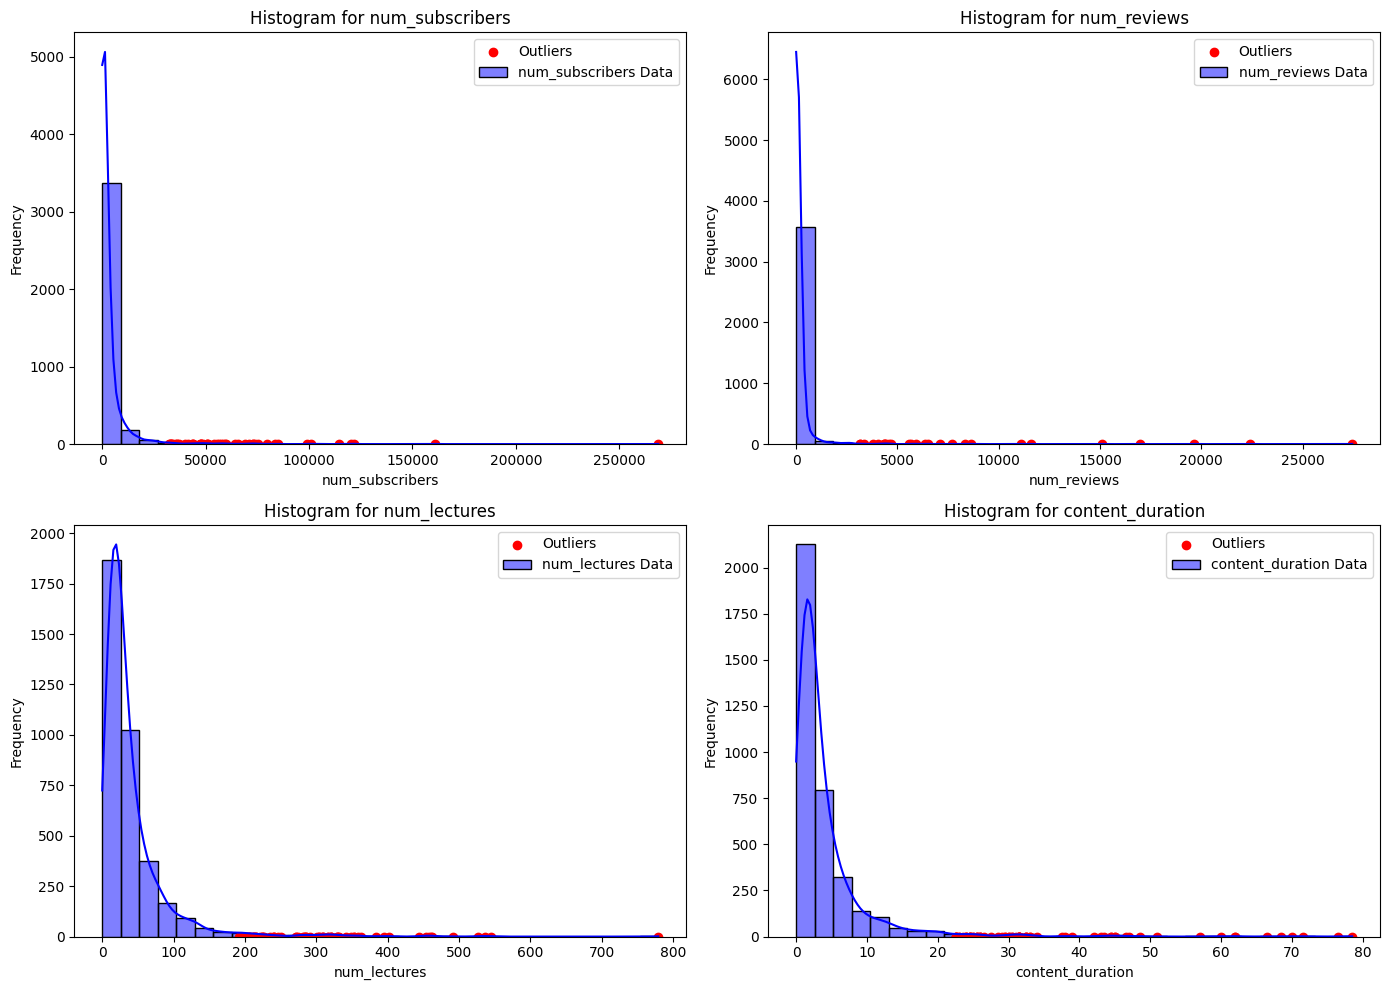

In [10]:
independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  

    sns.histplot(df[var], kde=True, color='blue', label=f'{var} Data', bins=30)

    z_scores = np.abs((df[var] - df[var].mean()) / df[var].std())  
    outliers_z_score = df[z_scores > 3]

    plt.scatter(outliers_z_score[var], np.zeros_like(outliers_z_score[var]), color='red', label='Outliers')

    plt.title(f'Histogram for {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout() 
plt.show()


    


Histogram with outliers

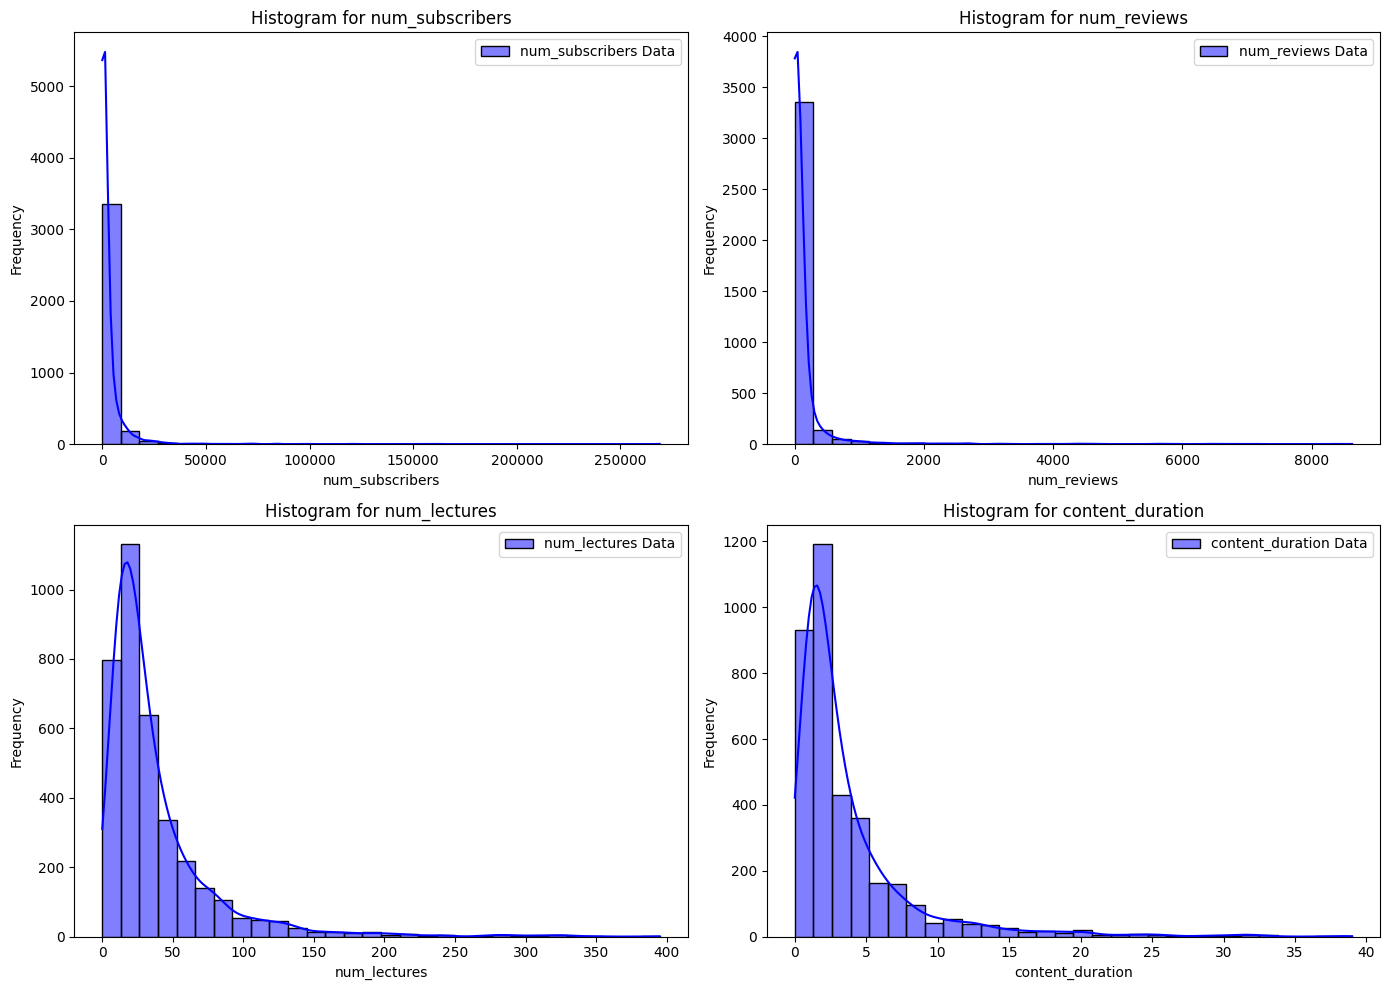

In [11]:
independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  


    sns.histplot(df_no_outliers_udemy[var], kde=True, color='blue', label=f'{var} Data', bins=30)
    
    plt.title(f'Histogram for {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  
plt.show()


    


BOX 7 Perform a Chi-Square Test for Goodness of Fit on observed categorical counts.

In [12]:
def chi_square_test(observed_values, alpha=0.05):

    expected_counts = [sum(observed_values) / len(observed_values)] * len(observed_values)

    chi2_stat, p_value = chisquare(f_obs=observed_values, f_exp=expected_counts)

    result = "reject the null hypothesis" if p_value < alpha else "fail to reject the null hypothesis"
    
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")

    # print(f"Observed Values: {observed_values}")
    # print(f"Expected Values: {expected_counts}")
    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")
    # print(f"Result: {result}")
    
    return {
        f"Chi-Square Statistic: {chi2_stat}",
        f"P-Value: {p_value}",
        f"Result: {result}"
    }

Histogram only for web dev courses without outliers

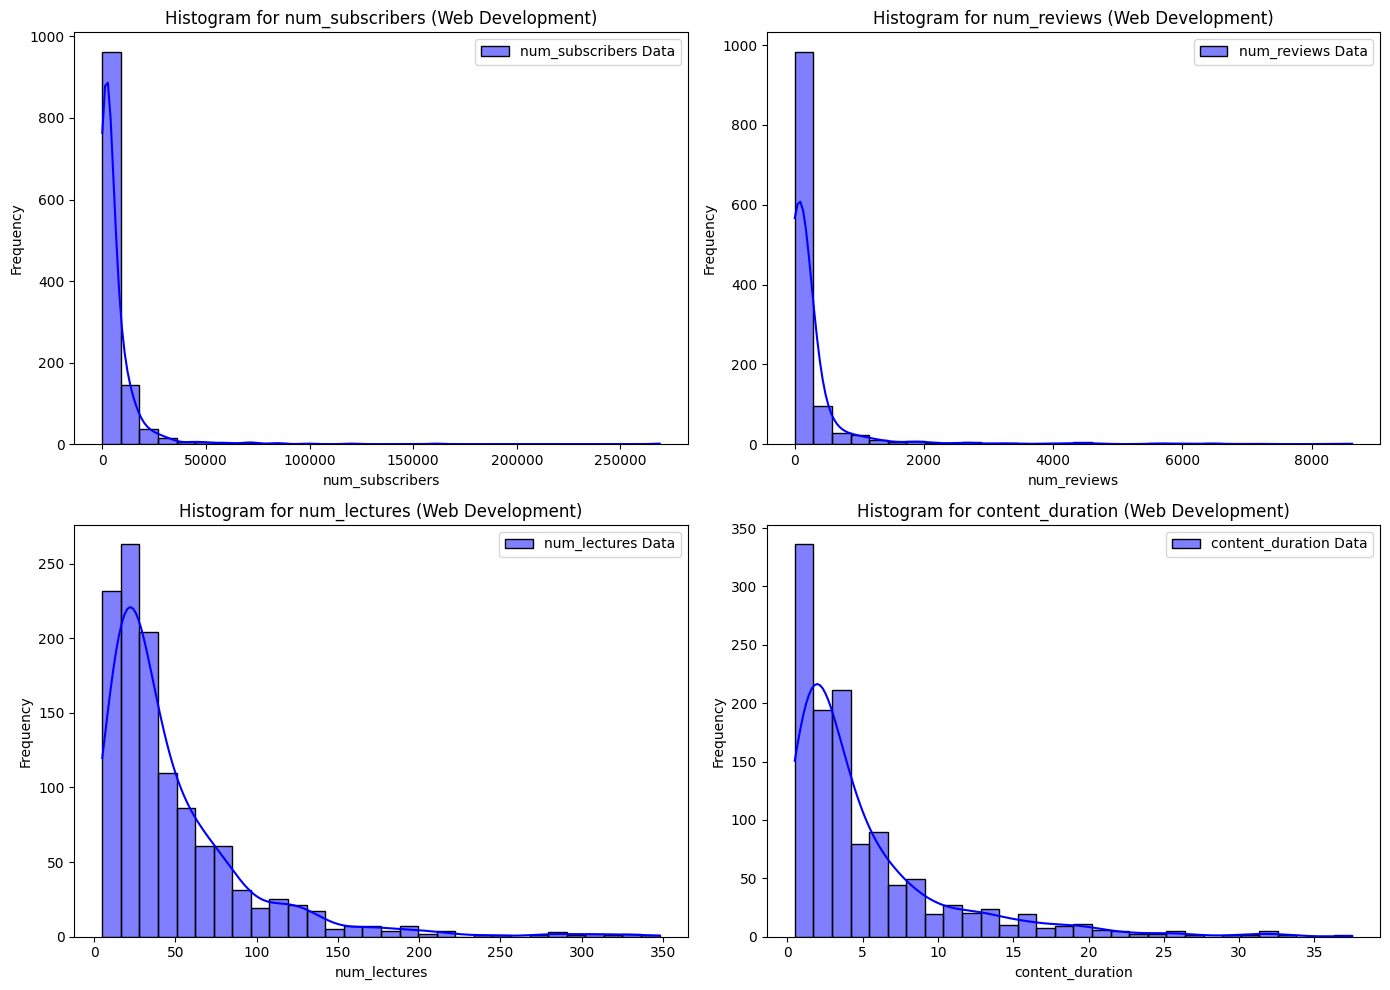

In [13]:
# Filter data for Web Development courses
web_dev_courses = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

plt.figure(figsize=(14, 10))

for i, var in enumerate(independent_vars, 1):
    plt.subplot(2, 2, i)  

    # Create histogram for Web Development courses only
    sns.histplot(web_dev_courses[var], kde=True, color='blue', label=f'{var} Data', bins=30)
    
    plt.title(f'Histogram for {var} (Web Development)')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()  
plt.show()


histogram for web dev courses without outliers by levels

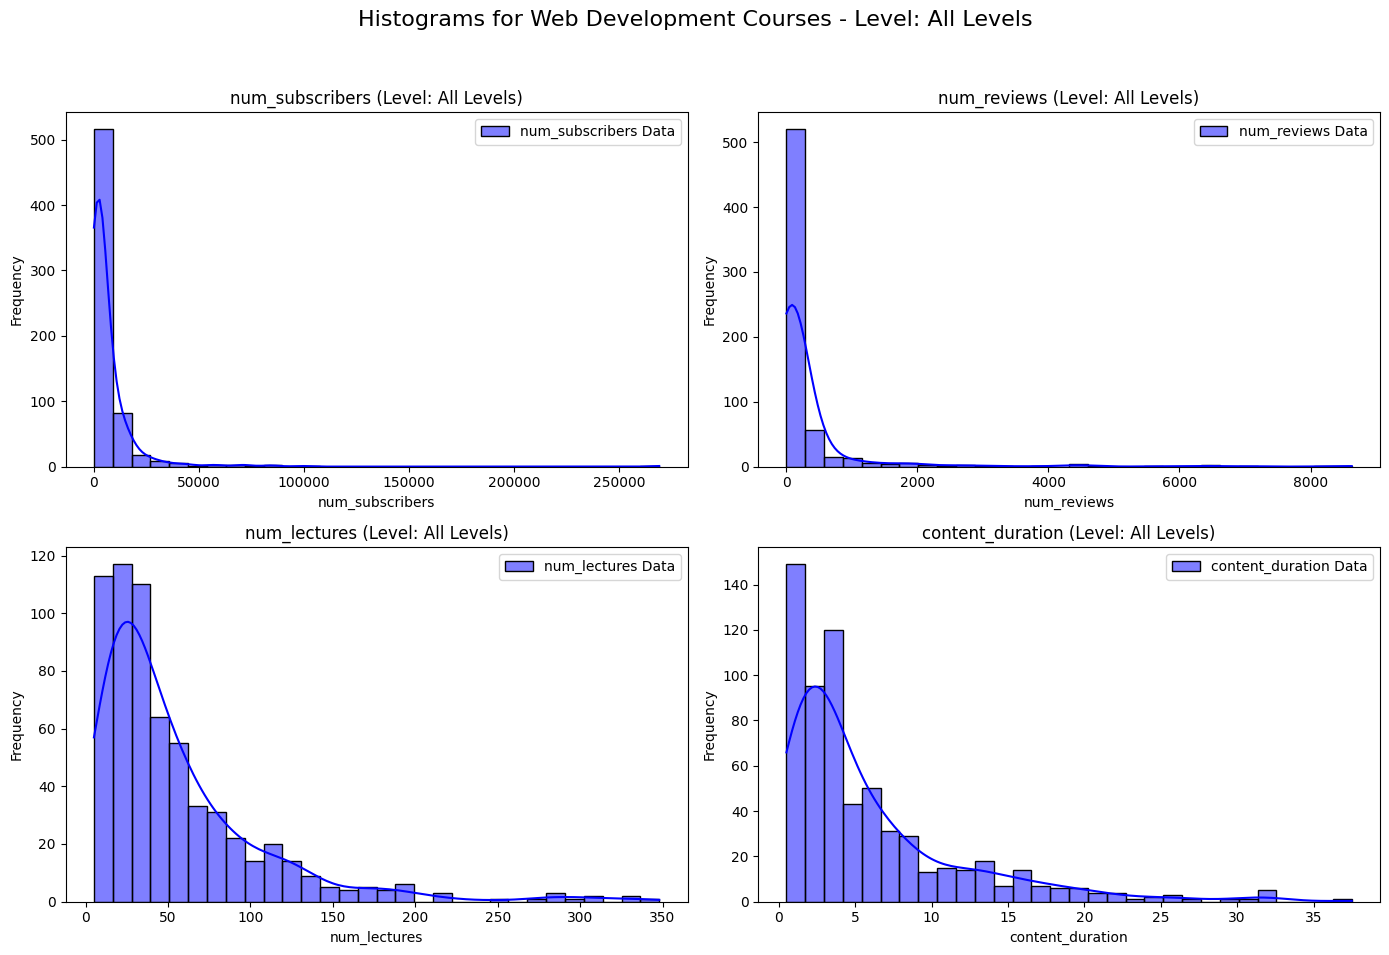

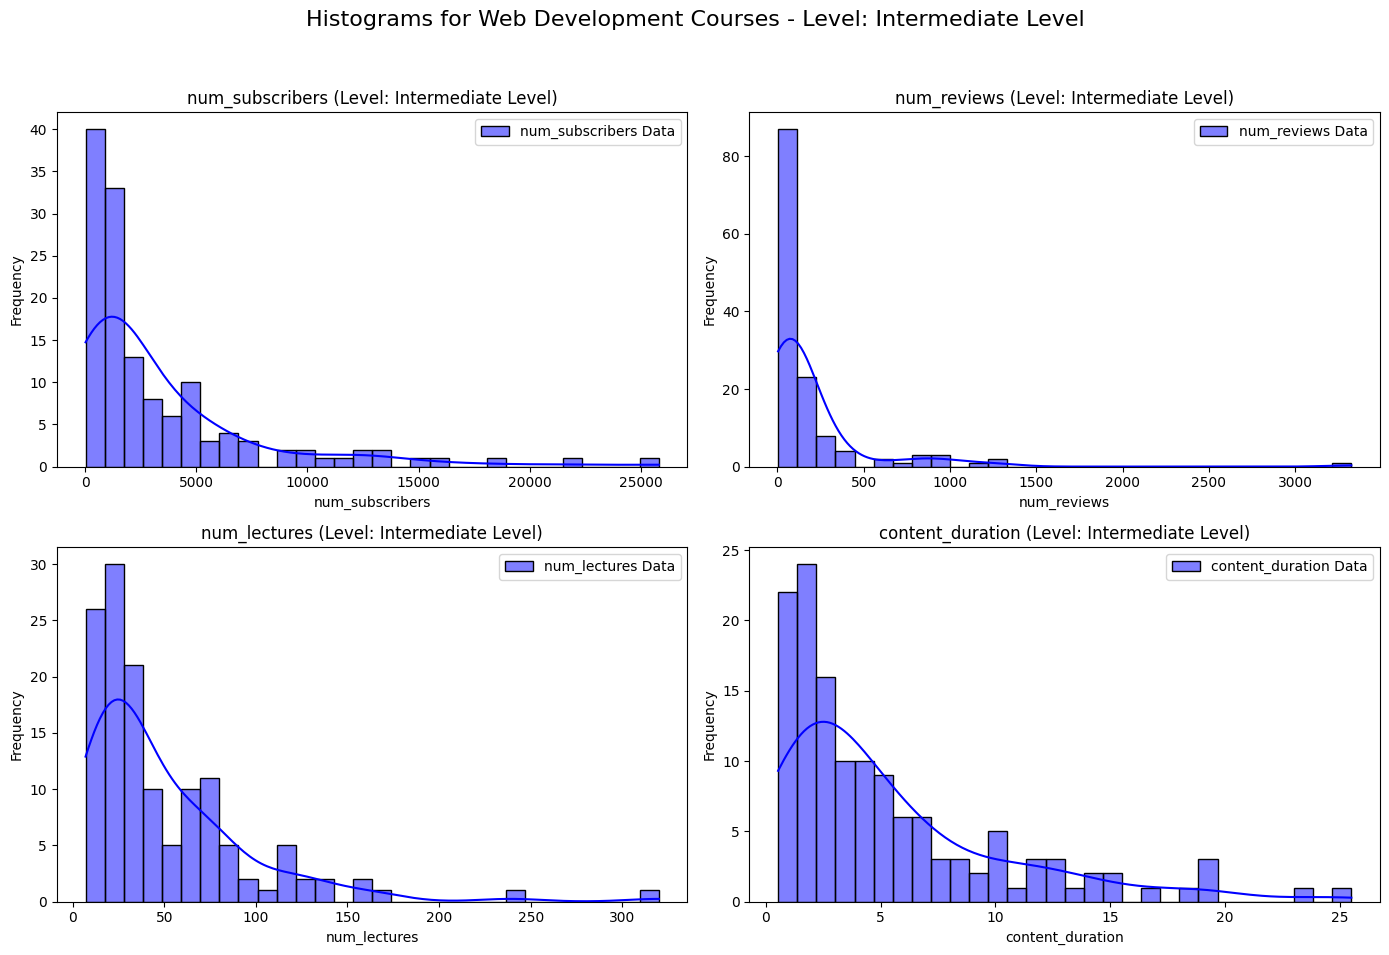

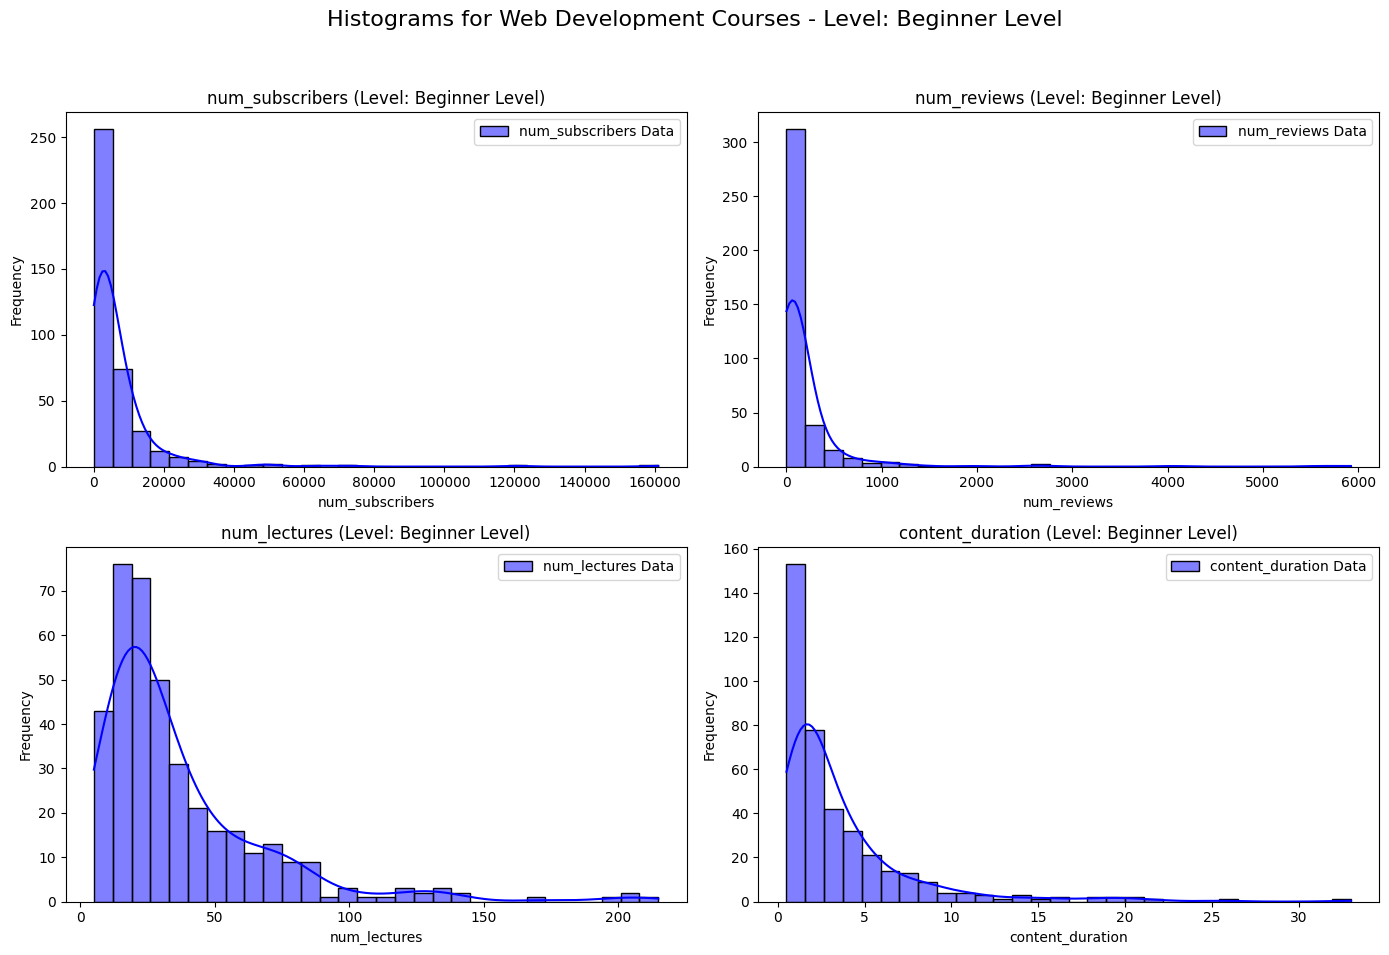

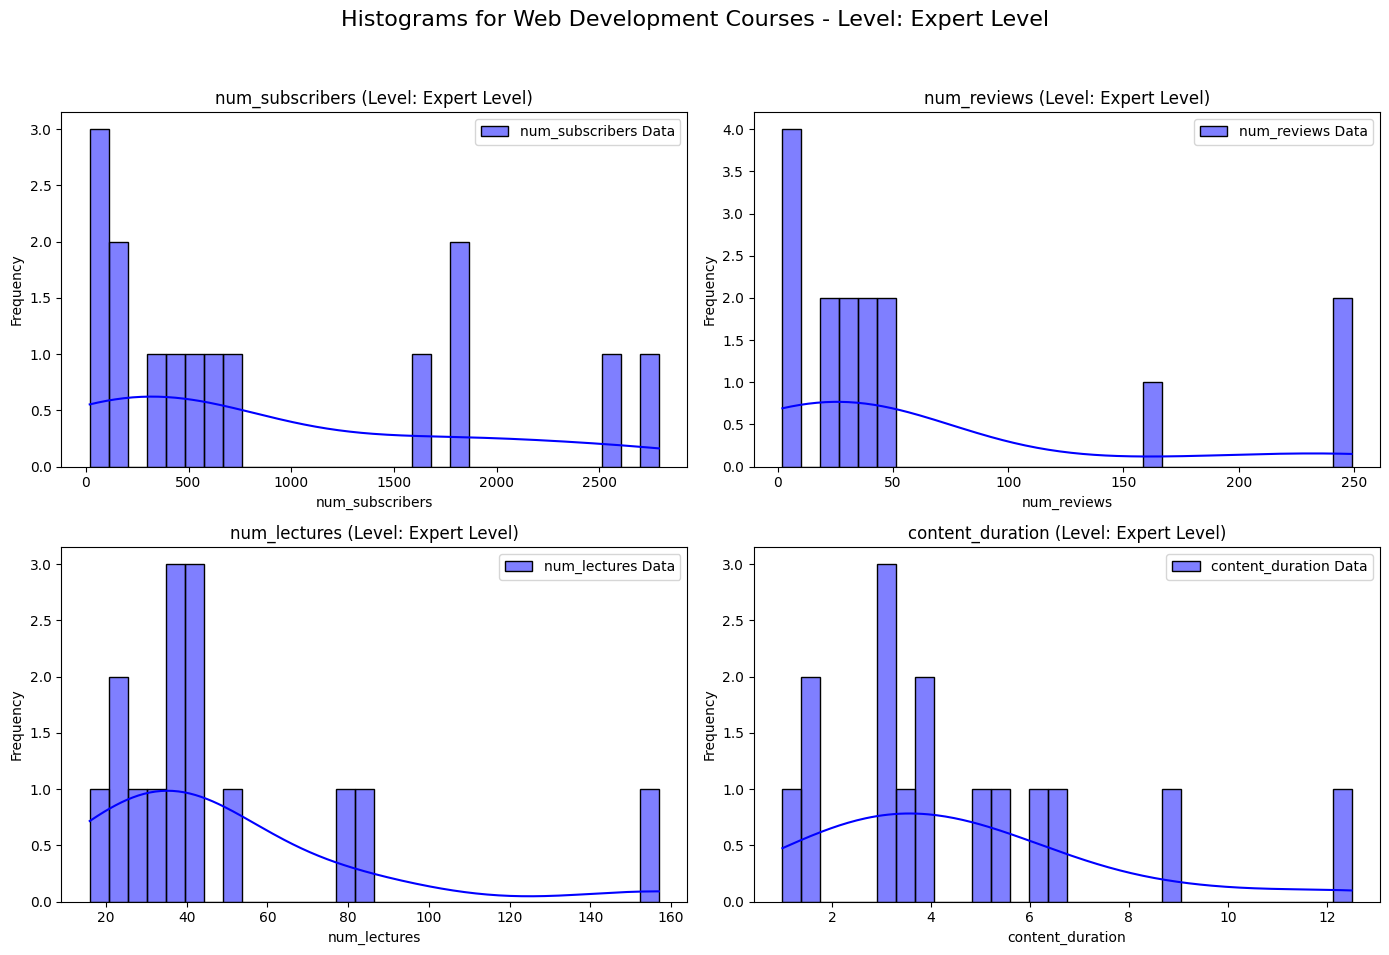

In [14]:
web_dev_courses = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

independent_vars = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

lecture_levels = web_dev_courses['level'].unique()

# Create histograms grouped by lecture level
for level in lecture_levels:
    level_data = web_dev_courses[web_dev_courses['level'] == level]
    plt.figure(figsize=(14, 10))
    plt.suptitle(f'Histograms for Web Development Courses - Level: {level}', fontsize=16)
    
    for i, var in enumerate(independent_vars, 1):
        plt.subplot(2, 2, i)

        sns.histplot(level_data[var], kde=True, color='blue', label=f'{var} Data', bins=30)
        
        plt.title(f'{var} (Level: {level})')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()


BOX 8 BARCHART: count all the courses taking into account the subject

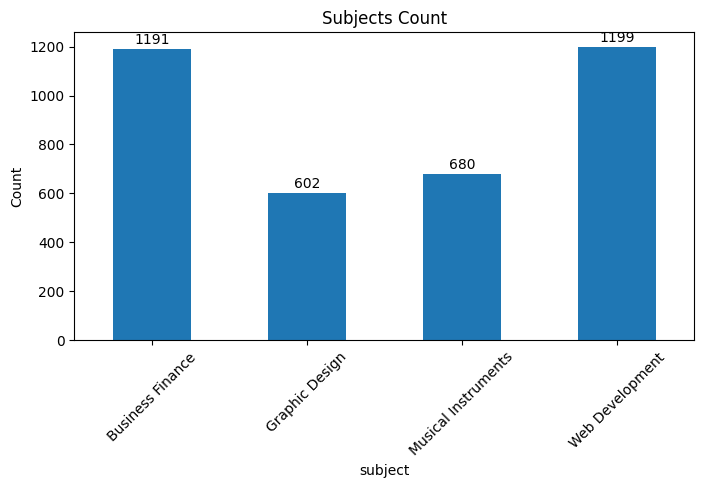

In [15]:
category = df.groupby('subject')['subject'].count()

plt.figure(figsize=(8, 4))
for i, v in enumerate(category.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')
category.plot(kind='bar')
plt.title('Subjects Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

BOX 9: Chi square for courses based on subj
H₀: There is no statistical difference in the number of couses per subject
H₁: There is a statistical difference in the number of couses per subject for at least one subject

In [16]:
observed_cat = category.values  
chi_square_test(observed_cat)

{'Chi-Square Statistic: 337.67973856209153',
 'P-Value: 6.938242224702548e-73',
 'Result: reject the null hypothesis'}

BOX 10 BARCHART: avg duration per subject

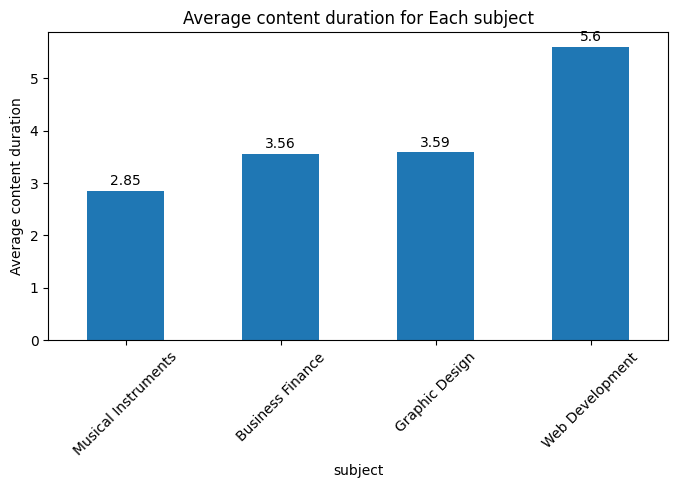

In [17]:
avg_duration_subj = df.groupby('subject')['content_duration'].mean().sort_values(ascending=True)

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_duration_subj.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_duration_subj.plot(kind='bar')
plt.title('Average content duration for Each subject')
plt.xlabel('subject')
plt.ylabel('Average content duration')
plt.xticks(rotation=45)
plt.show()

BOX 11 Chi Square for avr duration based on each subject
H₀: all subjects have a similar value for the avg duration 
H₁: at least one subject has a different value for the avg duration

In [18]:
observed_avg_duration = avg_duration_subj.values
chi_square_test(observed_avg_duration)

{'Chi-Square Statistic: 1.0738276876778154',
 'P-Value: 0.7833956419700129',
 'Result: fail to reject the null hypothesis'}

BOX 12 BARCHART: total number of subscribers enrolled for each subject

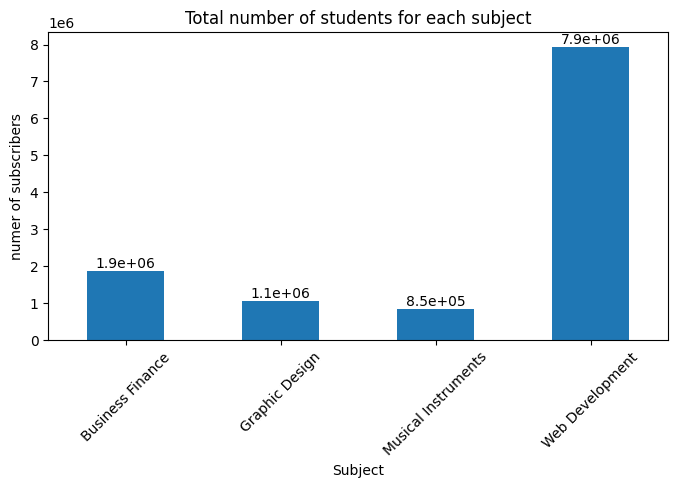

In [19]:
total_enrolled_stud = df.groupby('subject')['num_subscribers'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_enrolled_stud.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_enrolled_stud.plot(kind='bar')
plt.title('Total number of students for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of subscribers')
plt.xticks(rotation=45)
plt.show()

BOX 13 Chi Square for total number of subscribers enrolled in each subject
H₀: all subjects have a similar number of students enrolled
H₁: at least one subject has a different number of students enrolled

In [20]:
observed_total_subscribers = total_enrolled_stud.values
chi_square_test(observed_total_subscribers)

{'Chi-Square Statistic: 11616610.926223781',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 13.1: Avg number of students for each subj

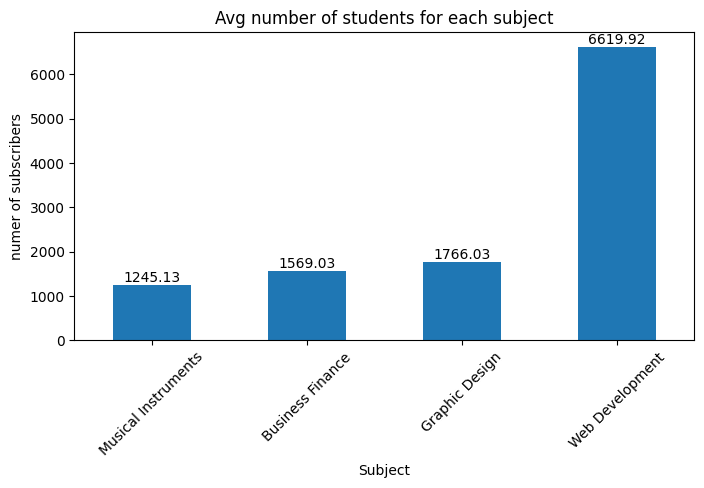

In [21]:
avg_enrolled_stud = df.groupby('subject')['num_subscribers'].mean().sort_values(ascending=True)

plt.figure(figsize=(8, 4))

for i, v in enumerate(avg_enrolled_stud.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')

avg_enrolled_stud.plot(kind='bar')
plt.title('Avg number of students for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of subscribers')
plt.xticks(rotation=45)
plt.show()

Chi Square for average number of subscribers enrolled in each subject
H₀: all subjects have a similar average number of students enrolled
H₁: at least one subject has a different average number of students enrolled

In [22]:
observed_avg_subscribers = avg_enrolled_stud.values
chi_square_test(observed_total_subscribers)

{'Chi-Square Statistic: 11616610.926223781',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 14 BARCHART: total number of reviews for each subject

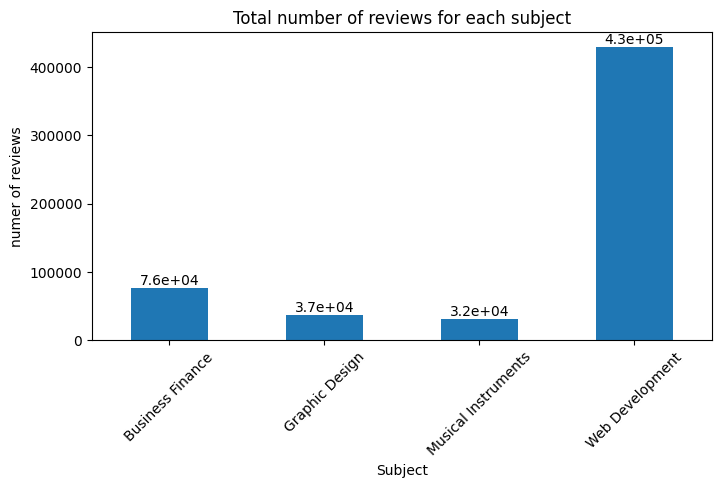

In [23]:
total_reviews = df.groupby('subject')['num_reviews'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_reviews.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_reviews.plot(kind='bar')
plt.title('Total number of reviews for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of reviews')
plt.xticks(rotation=45)
plt.show()

BOX 15: Chi Square test for total number of reviews
H0: The is no significant difference in the number of reviews across all subjects
H1: At least one subject has a different number of reviews that others

In [24]:
observed_total_reviews = total_reviews.values
chi_square_test(observed_total_reviews)

{'Chi-Square Statistic: 767589.4577879331',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 14.1: Avg number of reviews per subject

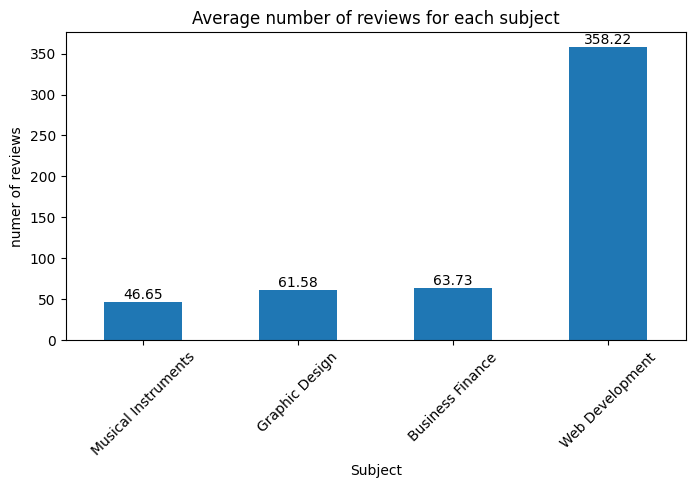

In [25]:
avg_reviews = df.groupby('subject')['num_reviews'].mean().sort_values(ascending=True)



plt.figure(figsize=(8, 4))

for i, v in enumerate(avg_reviews.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')

avg_reviews.plot(kind='bar')
plt.title('Average number of reviews for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of reviews')
plt.xticks(rotation=45)
plt.show()

Chi Square test for avg number of reviews
H0: The is no significant difference in the avg number of reviews across all subjects
H1: At least one subject has a different avg number of reviews that others

In [26]:
observed_avg_reviews = avg_reviews.values
chi_square_test(observed_total_reviews)

{'Chi-Square Statistic: 767589.4577879331',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 16 BARCHART: total number of professors for each subject

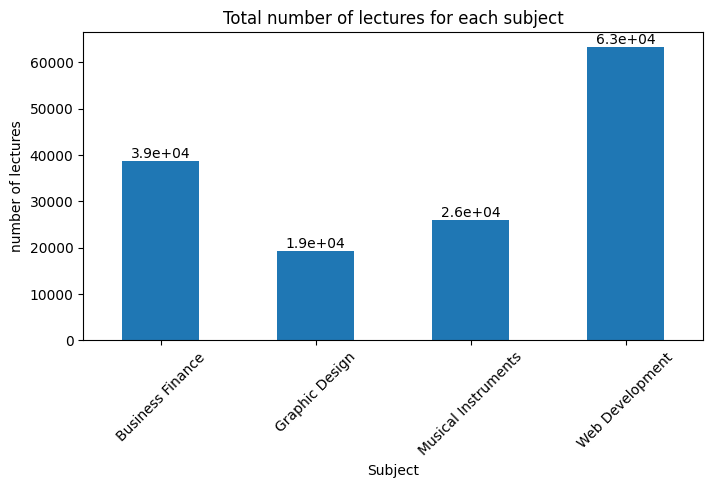

In [27]:
total_professors = df.groupby('subject')['num_lectures'].sum()

plt.figure(figsize=(8, 4))

for i, v in enumerate(total_professors.values):
    scientific_notation = "{:.1e}".format(v) 
    plt.text(i, v + v * 0.001, scientific_notation, ha='center', va='bottom')

total_professors.plot(kind='bar')
plt.title('Total number of lectures for each subject')
plt.xlabel('Subject')
plt.ylabel('number of lectures')
plt.xticks(rotation=45)
plt.show()

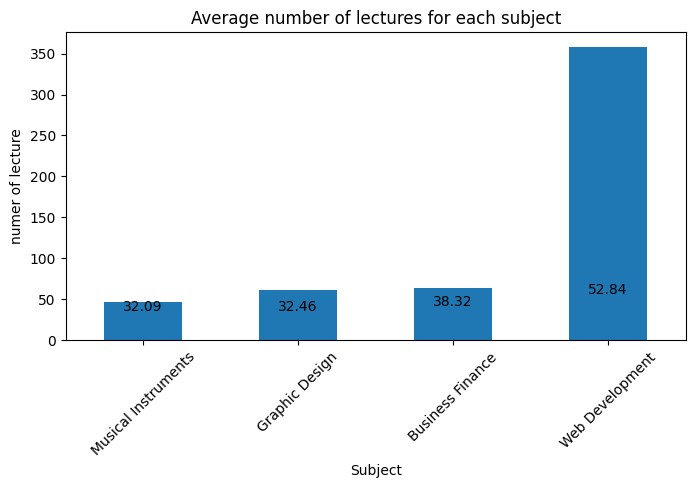

In [28]:
avg_lectures = df.groupby('subject')['num_lectures'].mean().sort_values(ascending=True)



plt.figure(figsize=(8, 4))

for i, v in enumerate(avg_lectures.values):
    plt.text(i, round(v, 2) + .05, str(round(v, 2)), ha='center', va='bottom')

avg_reviews.plot(kind='bar')
plt.title('Average number of lectures for each subject')
plt.xlabel('Subject')
plt.ylabel('numer of lecture')
plt.xticks(rotation=45)
plt.show()

Chi Square test for avg number of lecutes
H0: The is no significant difference in the avg number of lecutures across all subjects
H1: At least one subject has a different avg number of lectures that others

In [29]:
observed_avg_lectures = avg_lectures.values
chi_square_test(observed_total_reviews)

{'Chi-Square Statistic: 767589.4577879331',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 17: Chi Square for number of professors
H0: There is no statistical difference between the number of professors per subject
H1: At last one subject has a different number of professors than the others

In [30]:
observed_total_professors= total_professors.values
chi_square_test(observed_total_professors)

{'Chi-Square Statistic: 30658.86730893178',
 'P-Value: 0.0',
 'Result: reject the null hypothesis'}

BOX 18 BARCHART: avg prices for each subject

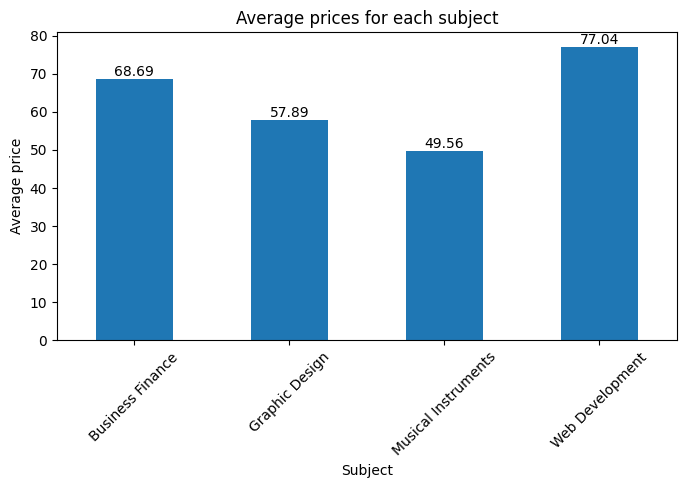

In [31]:
avg_price = df.groupby('subject')['price'].mean()

plt.figure(figsize=(8, 4) ,linewidth=2)
for i, v in enumerate(avg_price.values):
    plt.text(i, round(v,2) + .05, str(round(v, 2)), ha='center', va='bottom')
avg_price.plot(kind='bar')
plt.title('Average prices for each subject')
plt.xlabel('Subject')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.show()

BOX 19: Chi Square test for avg prices per subject
H0: There is no statistical difference between the avg price per subject
H1: At last one subject has a different agv price than the others

In [32]:
observed_avg_price = avg_price.values
chi_square_test(observed_avg_price)

{'Chi-Square Statistic: 6.88579963278157',
 'P-Value: 0.07562818840722958',
 'Result: fail to reject the null hypothesis'}

BOX 20: Checking price values over time for every category

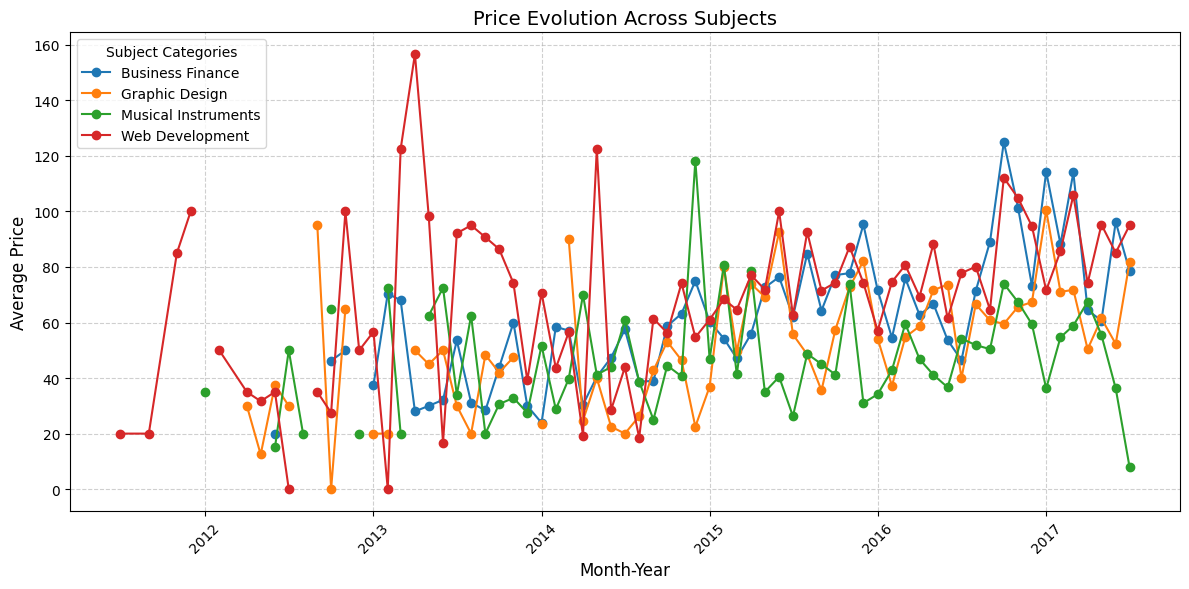

In [33]:
df["published_timestamp"] = pd.to_datetime(df["published_timestamp"])
df["Month-Year"] = df["published_timestamp"].dt.strftime("%b-%Y")

grouped = df.groupby(["subject", "Month-Year"], as_index=False)["price"].mean()

pivoted = grouped.pivot(index="Month-Year", columns="subject", values="price")

pivoted.index = pd.to_datetime(pivoted.index, format="%b-%Y")
pivoted = pivoted.sort_index()

plt.figure(figsize=(12, 6))
for category in pivoted.columns:
    plt.plot(pivoted.index, pivoted[category], marker="o", label=category)

plt.title("Price Evolution Across Subjects", fontsize=14)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.legend(title="Subject Categories")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for each subject in pivoted DataFrame
print("ADF Test Results for Price Evolution Across Subjects:\n")

for category in pivoted.columns:
    print(f"Subject: {category}")
    adf_result = adfuller(pivoted[category].dropna())  # Drop NaN values
    print(f"   ADF Statistic: {adf_result[0]:.4f}")
    print(f"   p-value: {adf_result[1]:.4f}")
    print("   Critical Values:")
    for key, value in adf_result[4].items():
        print(f"      {key}: {value:.4f}")
    if adf_result[1] < 0.05:
        print("   The time series is stationary (reject null hypothesis).")
    else:
        print("   The time series is NOT stationary (fail to reject null).")

# Test overall average price across all subjects
pivoted["Overall_Avg"] = pivoted.mean(axis=1)

print("\nOverall Average Price Across Subjects:")
adf_result_overall = adfuller(pivoted["Overall_Avg"].dropna())
print(f"   ADF Statistic: {adf_result_overall[0]:.4f}")
print(f"   p-value: {adf_result_overall[1]:.4f}")
print("   Critical Values:")
for key, value in adf_result_overall[4].items():
    print(f"      {key}: {value:.4f}")
if adf_result_overall[1] < 0.05:
    print("   The overall time series is stationary (reject null hypothesis).")
else:
    print("   The overall time series is NOT stationary (fail to reject null).")


ADF Test Results for Price Evolution Across Subjects:

Subject: Business Finance
   ADF Statistic: -0.1580
   p-value: 0.9433
   Critical Values:
      1%: -3.5746
      5%: -2.9240
      10%: -2.6000
   The time series is NOT stationary (fail to reject null).
Subject: Graphic Design
   ADF Statistic: -3.5328
   p-value: 0.0072
   Critical Values:
      1%: -3.5507
      5%: -2.9138
      10%: -2.5946
   The time series is stationary (reject null hypothesis).
Subject: Musical Instruments
   ADF Statistic: -3.9500
   p-value: 0.0017
   Critical Values:
      1%: -3.5529
      5%: -2.9147
      10%: -2.5951
   The time series is stationary (reject null hypothesis).
Subject: Web Development
   ADF Statistic: -4.6694
   p-value: 0.0001
   Critical Values:
      1%: -3.5507
      5%: -2.9138
      10%: -2.5946
   The time series is stationary (reject null hypothesis).

Overall Average Price Across Subjects:
   ADF Statistic: -1.9081
   p-value: 0.3282
   Critical Values:
      1%: -3.5352
 

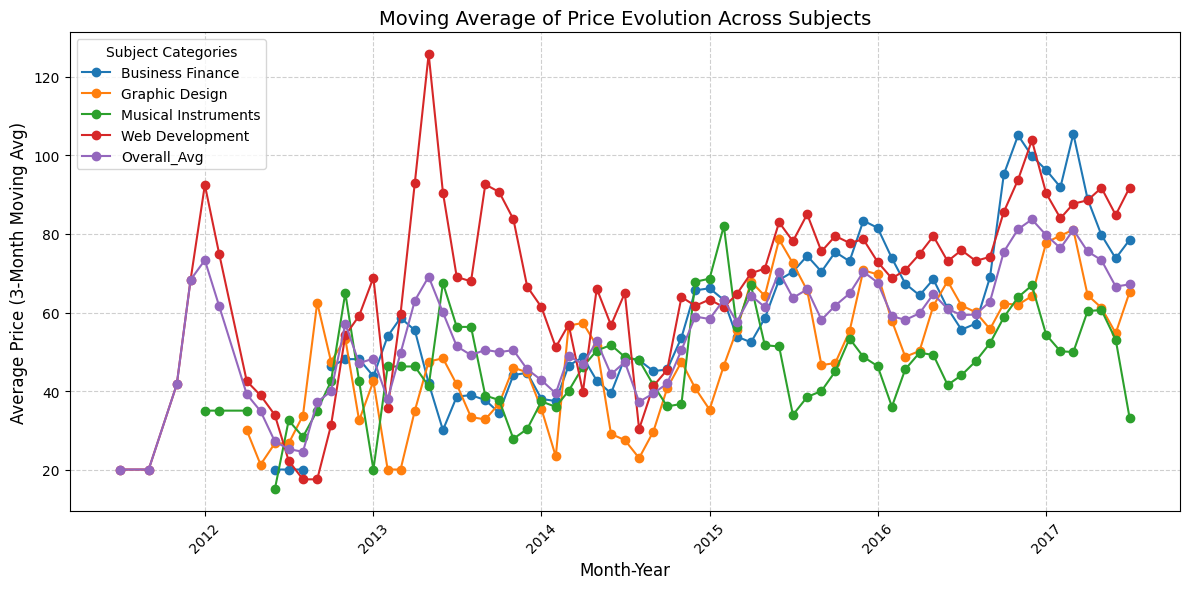

In [35]:
moving_avg = pivoted.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(12, 6))

for category in moving_avg.columns:
    plt.plot(moving_avg.index, moving_avg[category], marker="o", label=category)

plt.title("Moving Average of Price Evolution Across Subjects", fontsize=14)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Average Price (3-Month Moving Avg)", fontsize=12)
plt.legend(title="Subject Categories")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


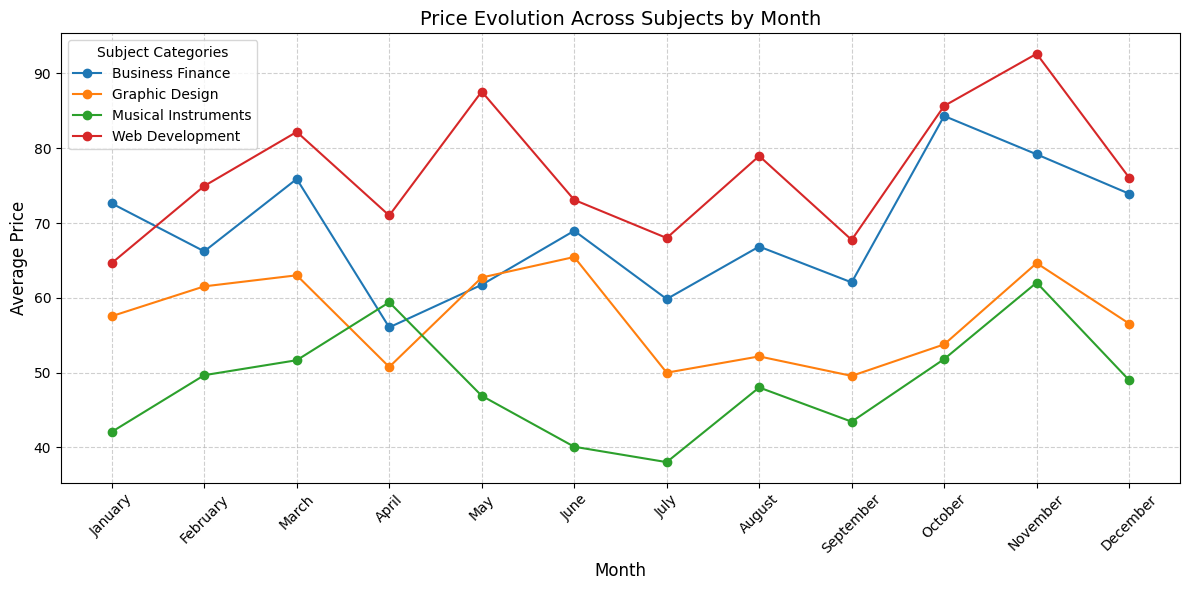

In [36]:
df["Month"] = df["published_timestamp"].dt.strftime("%B")

grouped = df.groupby(["subject", "Month"], as_index=False)["price"].mean()

month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]
grouped["Month"] = pd.Categorical(grouped["Month"], categories=month_order, ordered=True)
grouped = grouped.sort_values("Month")

pivoted = grouped.pivot(index="Month", columns="subject", values="price")

plt.figure(figsize=(12, 6))
for category in pivoted.columns:
    plt.plot(pivoted.index, pivoted[category], marker="o", label=category)

plt.title("Price Evolution Across Subjects by Month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.legend(title="Subject Categories")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



ADF for stationarity 
H0: The time series is not stationary
H1:The time series is stationary

In [37]:

# Reusing the 'pivoted' DataFrame
results = {}

# Perform the ADF test for each subject
for category in pivoted.columns:
    print(f"\nADF Test for {category}:")
    adf_result = adfuller(pivoted[category].dropna())  # Drop NaN values
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    if adf_result[1] < 0.05:
        print("The time series is stationary (reject null hypothesis).")
    else:
        print("The time series is NOT stationary (fail to reject null).")



ADF Test for Business Finance:
ADF Statistic: -2.5780
p-value: 0.0976
Critical Values:
   1%: -4.2232
   5%: -3.1894
   10%: -2.7298
The time series is NOT stationary (fail to reject null).

ADF Test for Graphic Design:
ADF Statistic: -0.6675
p-value: 0.8550
Critical Values:
   1%: -4.9387
   5%: -3.4776
   10%: -2.8439
The time series is NOT stationary (fail to reject null).

ADF Test for Musical Instruments:
ADF Statistic: -5.6381
p-value: 0.0000
Critical Values:
   1%: -4.9387
   5%: -3.4776
   10%: -2.8439
The time series is stationary (reject null hypothesis).

ADF Test for Web Development:
ADF Statistic: -0.6434
p-value: 0.8609
Critical Values:
   1%: -4.9387
   5%: -3.4776
   10%: -2.8439
The time series is NOT stationary (fail to reject null).


doing first differential to make the time series staionary 

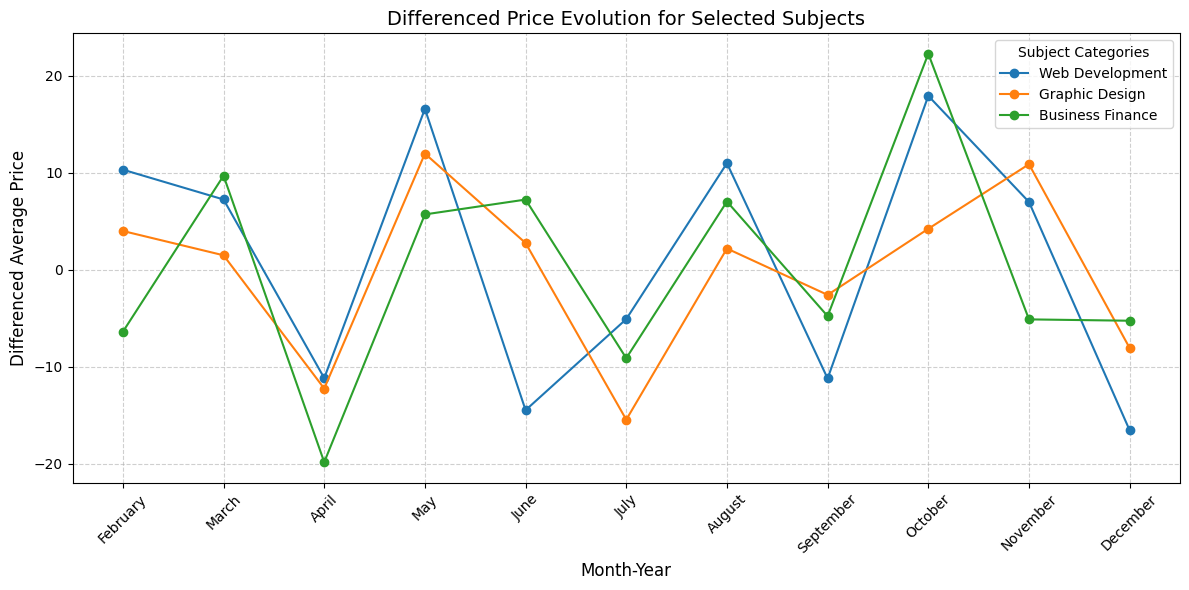

ADF Statistic for Web Development: -6.6141
p-value for Web Development: 0.0000
Critical Values:
   1%: -4.9387
   5%: -3.4776
   10%: -2.8439
--------------------------------------------------
ADF Statistic for Graphic Design: -4.6040
p-value for Graphic Design: 0.0001
Critical Values:
   1%: -4.9387
   5%: -3.4776
   10%: -2.8439
--------------------------------------------------
ADF Statistic for Business Finance: -5.1842
p-value for Business Finance: 0.0000
Critical Values:
   1%: -4.3316
   5%: -3.2330
   10%: -2.7487
--------------------------------------------------


In [38]:
subjects_of_interest = ["Web Development", "Graphic Design", "Business Finance"]
pivoted_selected = pivoted[subjects_of_interest]

# Apply first differencing to remove trend for selected subjects
pivoted_diff = pivoted_selected.diff().dropna()  # First differencing and dropping NaN values

# Plot the differenced data for selected subjects
plt.figure(figsize=(12, 6))
for category in pivoted_diff.columns:
    plt.plot(pivoted_diff.index, pivoted_diff[category], marker="o", label=category)

plt.title("Differenced Price Evolution for Selected Subjects", fontsize=14)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Differenced Average Price", fontsize=12)
plt.legend(title="Subject Categories")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Apply Augmented Dickey-Fuller test for each subject in the selected categories
for category in pivoted_diff.columns:
    adf_result = adfuller(pivoted_diff[category])
    print(f"ADF Statistic for {category}: {adf_result[0]:.4f}")
    print(f"p-value for {category}: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    print("-" * 50)

# If p-value < 0.05, we reject the null hypothesis and conclude the series is stationary.


In [39]:
df_new = df.copy()

subjects_of_interest = ["Web Development", "Graphic Design", "Business Finance"]
pivoted_selected = pivoted[subjects_of_interest]

pivoted_diff = pivoted_selected.diff().dropna()

for subject in subjects_of_interest:
    df_new.loc[df_new['subject'] == subject, 'price'] = df_new.loc[df_new['subject'] == subject, 'price'].diff()

print(df_new.head())
df_new.to_csv('udemy_database_new.csv', index=False)


   course_id                                       course_title  \
0    1070968                 Ultimate Investment Banking Course   
1    1113822  Complete GST Course & Certification - Grow You...   
2    1006314  Financial Modeling for Business Analysts and C...   
3    1210588  Beginner to Pro - Financial Analysis in Excel ...   
4    1011058       How To Maximize Your Profits Trading Options   

                                                 url  is_paid  price  \
0  https://www.udemy.com/ultimate-investment-bank...     True    NaN   
1      https://www.udemy.com/goods-and-services-tax/     True -125.0   
2  https://www.udemy.com/financial-modeling-for-b...     True  -30.0   
3  https://www.udemy.com/complete-excel-finance-c...     True   50.0   
4  https://www.udemy.com/how-to-maximize-your-pro...     True  105.0   

   num_subscribers  num_reviews  num_lectures               level  \
0             2147           23            51          All Levels   
1             2792        

BOX 21: Avg price per subject taking into account all categories

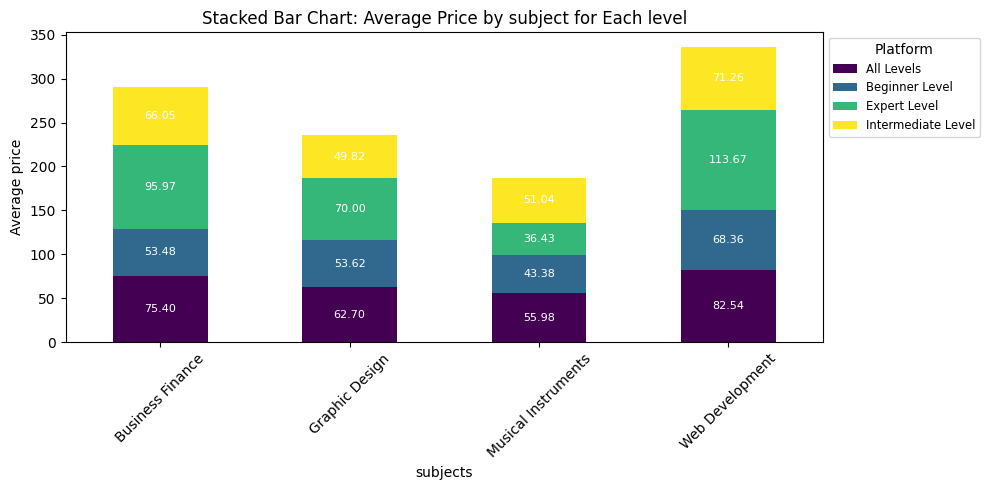

In [40]:
avg_price_per_category = df.groupby(['subject', 'level'])['price'].mean().unstack()

ax = avg_price_per_category.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    colormap='viridis'
)


for i, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        if bar.get_height() > 0:  
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,  
                bar.get_y() + height / 2,          
                f'{height:.2f}',                   
                ha='center', va='center', fontsize=8, color='white'
            )

plt.title('Stacked Bar Chart: Average Price by subject for Each level')
plt.xlabel('subjects')
plt.ylabel('Average price')
plt.xticks(rotation=45)
plt.legend(title='Platform', fontsize='small', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

plt.show()